In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
import parmap
from itertools import product
import sys
sys.path.append('../scripts/')
sys.path.append('../examples/')

from lindblad_solver import lindblad_solver
from utils import sx, sy, sz, si, init_qubit, normal_autocorr_generator
from dynamical_decoupling import dynamical_decoupling
from matplotlib import pyplot as plt

In [3]:
def single_carbon_H(t, dw_it):
    """
    Definition of the Hamiltonian for a single Carbon near a
    Nitrogen-Vacancy centre in diamond.

    Input:
    wL - the Larmor frequency of precession, controlled by the
    externally applied B field

    wh - the hyperfine coupling term describing the strength of
    spin-spin interaction between the Carbon and the NV

    theta - the angle between the applied B field and the vector
    pointing from the NV to the Carbon atom

    Output:
    The 4x4 Hamiltonian of the joint spin system.
    """
    wh = 
    wL = 
    theta = 
    A = wh * np.cos(theta)
    B = wh * np.sin(theta)
    noise_matrix = np.kron(sz,si) + np.kron(sz,si)

    return (A + wL) * np.kron((si - sz) / 2, sz / 2) + B * np.kron(
        (si - sz) / 2, sx / 2) + wL * np.kron((si + sz) / 2, sz / 2) + next(dw_it)*noise_matrix

In [4]:
def dd_parallel_noisy(H,tau_list, dt, N, mu, sigma, corr_time, repetitions):
    seed_list = np.arange(repetitions)

    values = list(product([H], [tau_list], dt, N, mu, sigma, corr_time, seed_list))

    results = parmap.starmap(dd_wrapper, values, pm_chunksize=3, pm_pbar=True)
    results = np.array(results)

    # Adapt results to input
    len_parameters = len(N) * len(dt) * len(mu) * len(sigma) * len(corr_time) 
    print(len_parameters)
    results = results.reshape((len_parameters, repetitions, tau_list.shape[0]))

    results_mean = results.mean(axis=-2)
    results_std = results.std(axis=-2) / np.sqrt(repetitions - 1)

    return results_mean,results_std



def dd_wrapper(H, tau_list, dt, N, mu, sigma, corr_time, seed):
    e = []

    # Initial state
    rho_0 = init_qubit([1, 0, 0])

    for tau_final in tau_list:
        _dt = min(dt,tau_final/5)
        dw_it = normal_autocorr_generator(mu, sigma, corr_time / dt / 2, seed)
        # H = add_noise(H,sz,mu, sigma, corr_time, _dt,  seed)
        tau = np.arange(tau_final, step=_dt)
        e.append(
            dynamical_decoupling(H, rho_0, N, tau_final, tau.shape[0], dw_it))
    return e



def dd_noise(H, tau_list, dt, N, mu, sigma, corr_time, seed):
    e = []
    
    #We add noise in Z componen
    noise_matrix = sz
    # Initial state
    rho_0 = init_qubit([1, 0, 0])

    for tau_final in tau_list:
        H = add_noise(H,mu,sigma,corr_time,dt, noise_matrix,seed)
        tau = np.arange(tau_final, step=dt)
        e.append(dynamical_decoupling(H, rho_0, N, tau_final, tau.shape[0]))
    return e

In [5]:
dt = [0.1]
N = [1]
sigma = [0.5, 1, 2]
mu = [0]
corr_time = [1000]

repetitions = 200
n_tau = 10
tau_list = np.linspace(1,20,n_tau)

mean,std = dd_parallel_noisy(H_noise,tau_list, dt, N, mu, sigma, corr_time, repetitions)

100%|██████████| 600/600 [00:05<00:00, 113.57it/s]

3


What we see in this simulation is that the increase of sigma goes as expected. It decreases the value of $T_2$ as long as $\sigma\tau_c >>1$.

[0.99875306+0.j 0.96114258+0.j 0.83955355+0.j 0.6511817 +0.j
 0.54962718+0.j 0.50726811+0.j 0.49624139+0.j 0.52465407+0.j
 0.52490483+0.j 0.48193102+0.j]
9.085602964160698


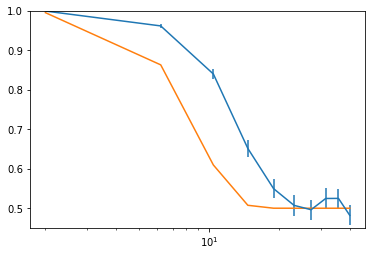

In [6]:
%matplotlib widget
plt.figure()
print(mean[0,:])
t = 2*tau_list
plt.errorbar(t, np.abs(mean[0, :]), np.abs(std[0, :]))
#plt.errorbar(t, mean[1, :], std[1, :])
#plt.errorbar(t, mean[2, :], std[1, :])

sigma = 4
T2 = np.cbrt(12*corr_time[0]/sigma**2)
print(T2)

y = 1/2 + 1/2 * np.exp(-(t/T2)**3)

plt.plot(t,y)

plt.xscale('log')
plt.ylim(0.45,1)

plt.show()

In [5]:
dt = [0.2,0.4]
N = [1,8,16]
sigma = [0.5]
mu = [0]
corr_time = [1000]

repetitions = 100
n_tau = 25
# Final t
t_list = np.logspace(0.5,2.4,n_tau)
print(t_list)
results = []
for n_rot in N:
    tau_list = t_list/2/n_rot
    results.append(dd_parallel_noisy(H_noise,tau_list, dt, [n_rot], mu, sigma, corr_time, repetitions))

[  3.16227766   3.7946058    4.5533741    5.4638655    6.55641849
   7.86743808   9.44060876  11.32835021  13.59356391  16.31172909
  19.57341781  23.48731289  28.18382931  33.81945983  40.58198942
  48.69675252  58.43414134  70.11861566  84.13951416 100.96402755
 121.15276586 145.37843856 174.4482699  209.33089647 251.18864315]


201it [00:04, 40.76it/s]                        

2



201it [00:05, 38.52it/s]                        

2



201it [00:05, 33.54it/s]                        

2


In [9]:
%matplotlib widget
t = t_list
for mean,std in results:  
    print(mean.shape)
    plt.errorbar(t, mean[0,:], std[0,:])

#sigma = 0.5
#N = 1
#T2 = np.cbrt(12*N**2*corr_time[0]/sigma**2)
#y = 1/2 + 1/2 * np.exp(-(N*t/T2)**3)

#plt.plot(N*t,y)

plt.xscale('log')
plt.ylim(0.45,1)

plt.show()

(2, 25)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(2, 25)
(2, 25)


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
